# 3.2-Clustering and further filtering

**Inés Sentís**

Date of execution 

In [1]:
Sys.Date()

[1] "2025-01-09"

## Introduction

Remove further cells and re-do normalization embeddings and clustering

In [2]:
timepoint <- "T1"

## Libraries

In [3]:
suppressMessages(suppressWarnings({
library(Seurat)
library(here)
library(glue)
library(tidyverse)
library(grid)
library(gridExtra)
library(ggplot2)
library(scater) 
library(scran)
}))

## Parameters

In [4]:
#dr_here(show_reason = TRUE)
source(here("SCGRES_83_84/sc_analysis/misc/paths.R"))
source(here("utils/bin.R"))

set.seed(0)

## Load data

In [5]:
seurat_obj <- readRDS(here(glue("{clust}/{robj_dir}/dimred_combined_object_{timepoint}.rds")))

## Remove potential erythrocytes

In [6]:
seurat_obj <- subset(x = seurat_obj, 
                     subset = HBM == 0 & HEMGN == 0 & HBG2 == 0)

In [7]:
print(table(rowSums(as.matrix(seurat_obj[['RNA']]@counts)) == 0))
  
keep_genes <- data.frame(rowSums(as.matrix(seurat_obj[['RNA']]@counts)) != 0)
colnames(keep_genes) <- "logical"
keep_genes <- subset(keep_genes, logical==TRUE)
seurat_obj[['RNA']]@counts <- seurat_obj[['RNA']]@counts[rownames(keep_genes), ]
seurat_obj[['RNA']]@data <- seurat_obj[['RNA']]@data[rownames(keep_genes), ]
seurat_obj

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 4.2 GiB”



FALSE  TRUE 
27745  1582 


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 4.2 GiB”


An object of class Seurat 
27745 features across 19310 samples within 1 assay 
Active assay: RNA (27745 features, 0 variable features)
 2 dimensional reductions calculated: pca, umap

In [8]:
seurat_obj <- DietSeurat(
  seurat_obj,
  counts = TRUE,
  data = TRUE,
  scale.data = FALSE,
  features = NULL,
  assays = NULL,
  dimreducs = FALSE,
  graphs = NULL
)

### Re-do embedding

In [9]:
seurat_obj <- NormalizeData(
  seurat_obj,
  normalization.method = "LogNormalize",
  scale.factor = 1e4
)

In [10]:
sce <- as.SingleCellExperiment(seurat_obj)
sce

class: SingleCellExperiment 
dim: 27745 19310 
metadata(0):
assays(2): counts logcounts
rownames(27745): MIR1302-2HG AL627309.1 ... AC010086.3 AC004556.3
rowData names(0):
colnames(19310): T1_1_AAACCTGAGAAGGCCT-1 T1_1_AAACCTGAGATCCCGC-1 ...
  T1_2_TTTGTCATCGTTACGA-1 T1_2_TTTGTCATCTGAAAGA-1
colData names(16): orig.ident nCount_RNA ... old.ident ident
reducedDimNames(0):
mainExpName: RNA
altExpNames(0):

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


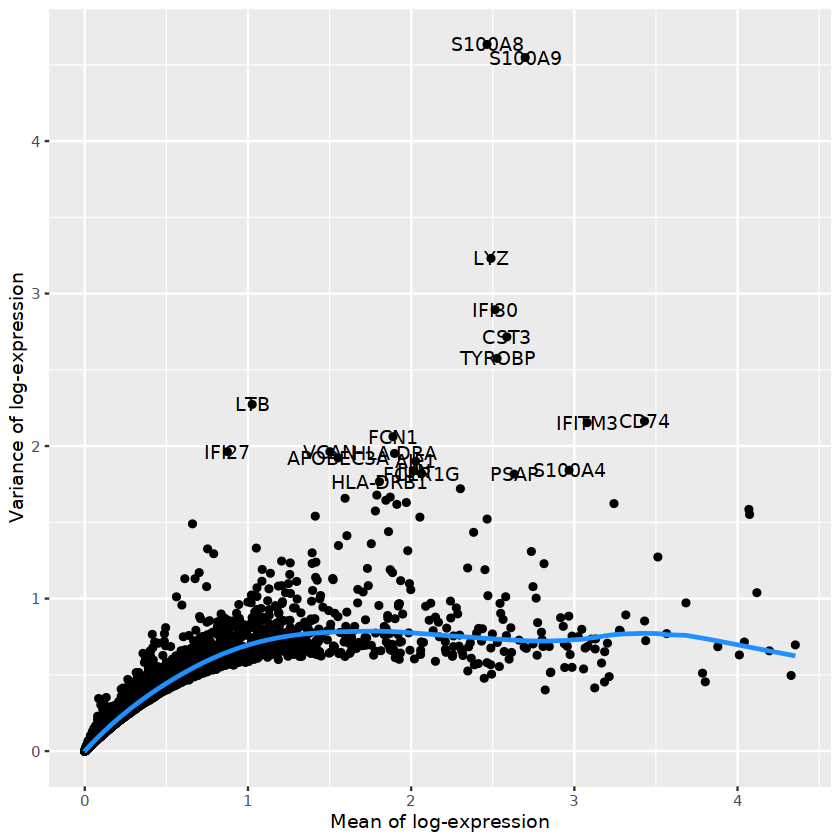

In [11]:
gene_var <- modelGeneVar(sce)

tops <- gene_var %>% 
    as.data.frame() %>% 
    arrange(desc(total)) %>% 
    head(n=20)

gene_var %>% 
  as.data.frame() %>% 
  ggplot(aes(mean, total)) +
  geom_point() +
  geom_line(aes(y = tech), colour = "dodgerblue", size = 1) +
  labs(x = "Mean of log-expression", y = "Variance of log-expression")+
  geom_text(data=tops, aes(mean,total,label=rownames(tops)))

In [12]:
hvgs <- getTopHVGs(gene_var,fdr.threshold = 0.05)
length(hvgs)

[1] 509

In [13]:
# remove TCR genes
hvgs <- hvgs[!grepl("^TR[ABDG][VJC]", hvgs)]

In [14]:
seurat_obj <- seurat_obj %>%
  ScaleData(features=hvgs) %>% 
  RunPCA(features=hvgs)

Centering and scaling data matrix

PC_ 1 
Positive:  TYROBP, CST3, IFI30, FCER1G, FCN1, AIF1, PSAP, LYZ, IFITM3, CTSS 
	   SPI1, SERPINA1, LST1, LYN, ZEB2, NAMPT, TYMP, MNDA, S100A11, LGALS1 
	   CD68, S100A9, S100A6, HLA-DRB1, HLA-DRA, FTL, CD74, APOBEC3A, SRGN, FTH1 
Negative:  CD3E, LTB, IL32, ETS1, PCED1B-AS1, CD69, CD3D, SKAP1, IL7R, RHOH 
	   CD7, CD247, LCK, LEF1, FLT3LG, BCL2, CAMK4, ITM2A, SPOCK2, PRKCH 
	   MAL, TCF7, ABLIM1, MALAT1, INPP4B, SATB1, SYNE2, BACH2, ICOS, AQP3 
PC_ 2 
Positive:  IFITM1, FOS, JUN, S100A10, ANXA1, TNFAIP3, FLT3LG, DUSP1, IL7R, IL32 
	   CD69, CD3D, CD3E, LCK, S100A4, SPOCK2, LEF1, MAL, CAMK4, IFITM3 
	   TCF7, CRIP1, S100A11, INPP4B, BCL2, NEAT1, ITM2A, ICOS, FTL, ETS1 
Negative:  JCHAIN, LILRA4, CLEC4C, NIBAN3, MZB1, PTPRS, SERPINF1, LINC01478, LINC01374, IGKC 
	   ITM2C, GZMB, AFF3, ALAS2, SNCA, HBA1, HBA2, CA1, HLA-DQA1, AHSP 
	   HBB, SELENBP1, PTCRA, TCL1A, HLA-DPB1, SLC4A1, HBD, HLA-DPA1, HLA-DRA, CD74 
PC_ 3 
Positive:  SNCA, ALAS2, HBA1, HB

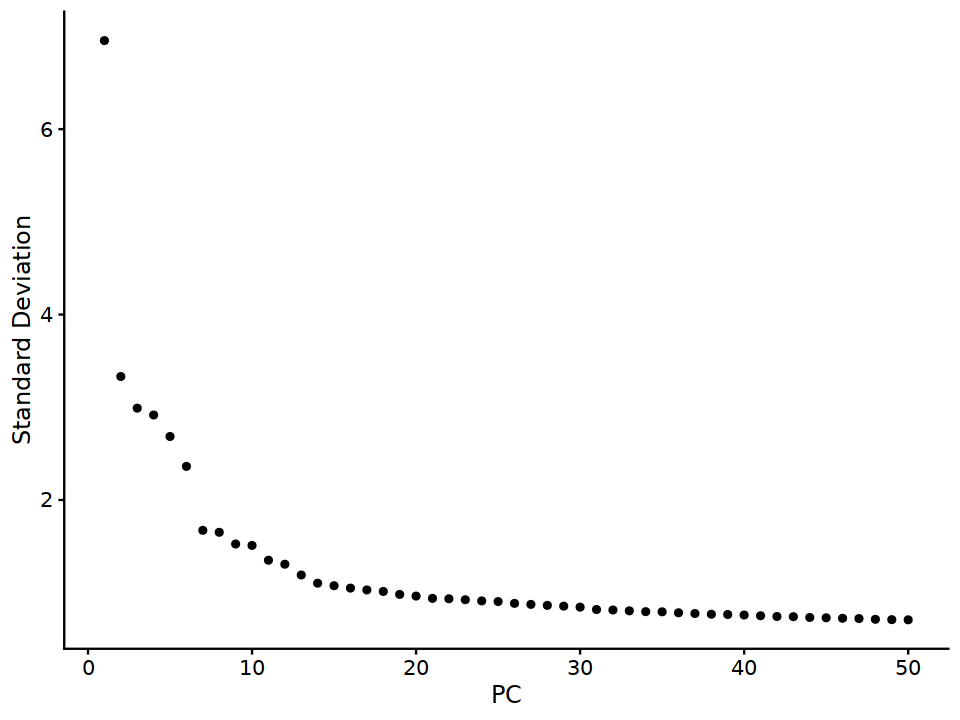

In [15]:
options(repr.plot.width = 8, repr.plot.height = 6)
ElbowPlot(seurat_obj, n=50)

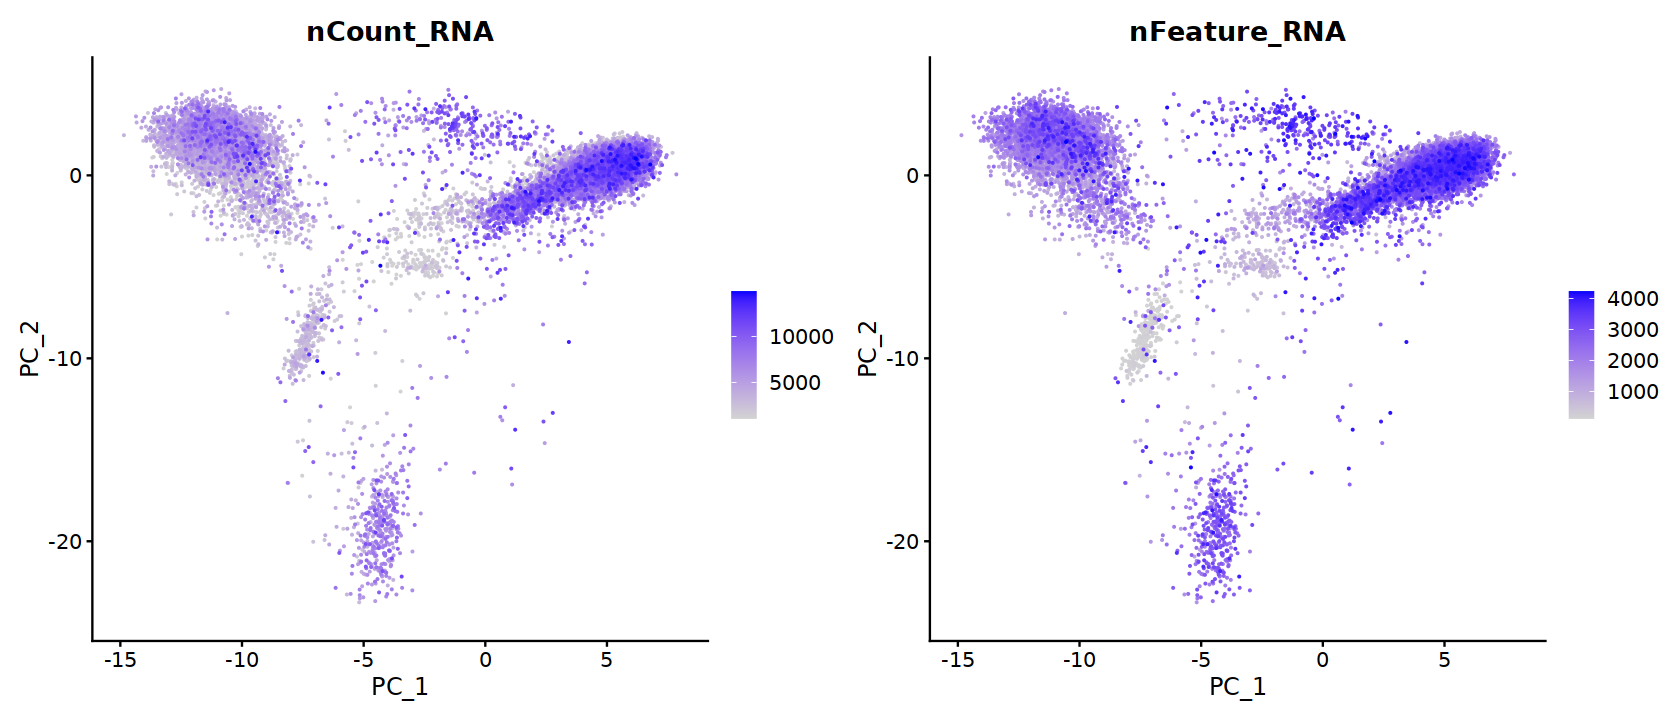

In [16]:
options(repr.plot.width = 14, repr.plot.height = 6)
FeaturePlot(object = seurat_obj, reduction = "pca",
        features = c("nCount_RNA","nFeature_RNA"), order=T)

In [17]:
seurat_obj <- RunUMAP(
  seurat_obj,
  dims = 1:15,
  reduction = "pca",
  reduction.name = "umap",
  reduction.key = "UMAP_"
)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
16:50:20 UMAP embedding parameters a = 0.9922 b = 1.112

16:50:20 Read 19310 rows and found 15 numeric columns

16:50:20 Using Annoy for neighbor search, n_neighbors = 30

16:50:20 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

16:50:23 Writing NN index file to temp file /scratch_tmp/33937378/RtmpMsZ3tu/filef1341e664642

16:50:23 Searching Annoy index using 1 thread, search_k = 3000

16:50:30 Annoy recall = 100%

16:50:30 Commencing smooth kNN distance calibration using 1 thread
 with ta

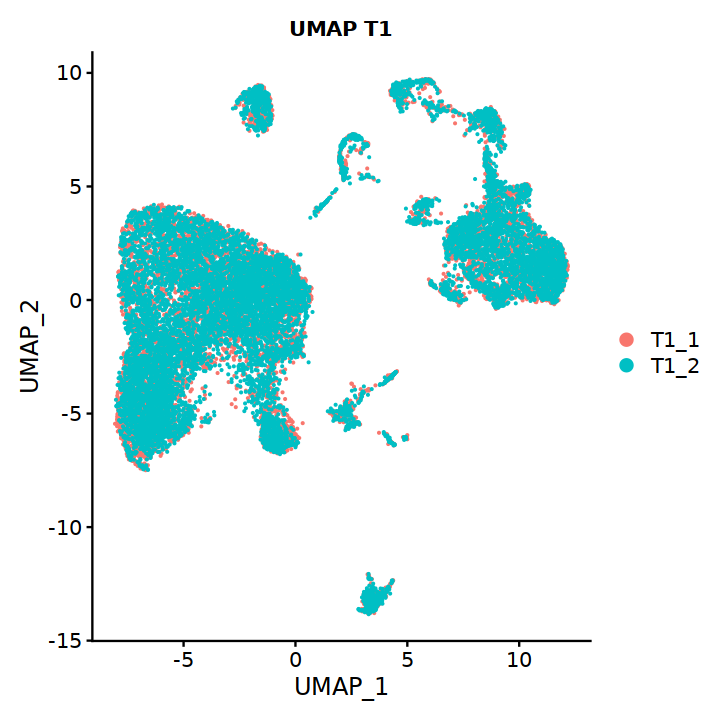

In [18]:
options(repr.plot.width = 6, repr.plot.height = 6, warn=-1,verbose = FALSE)
DimPlot(
  seurat_obj,
  reduction = "umap",
  group.by = "sample_id",
  pt.size = 0.1
) + ggtitle(glue('UMAP {timepoint}')) + 
    theme(plot.title = element_text(hjust = 0.5, size = 12, face = "bold"))

## Remove doublets

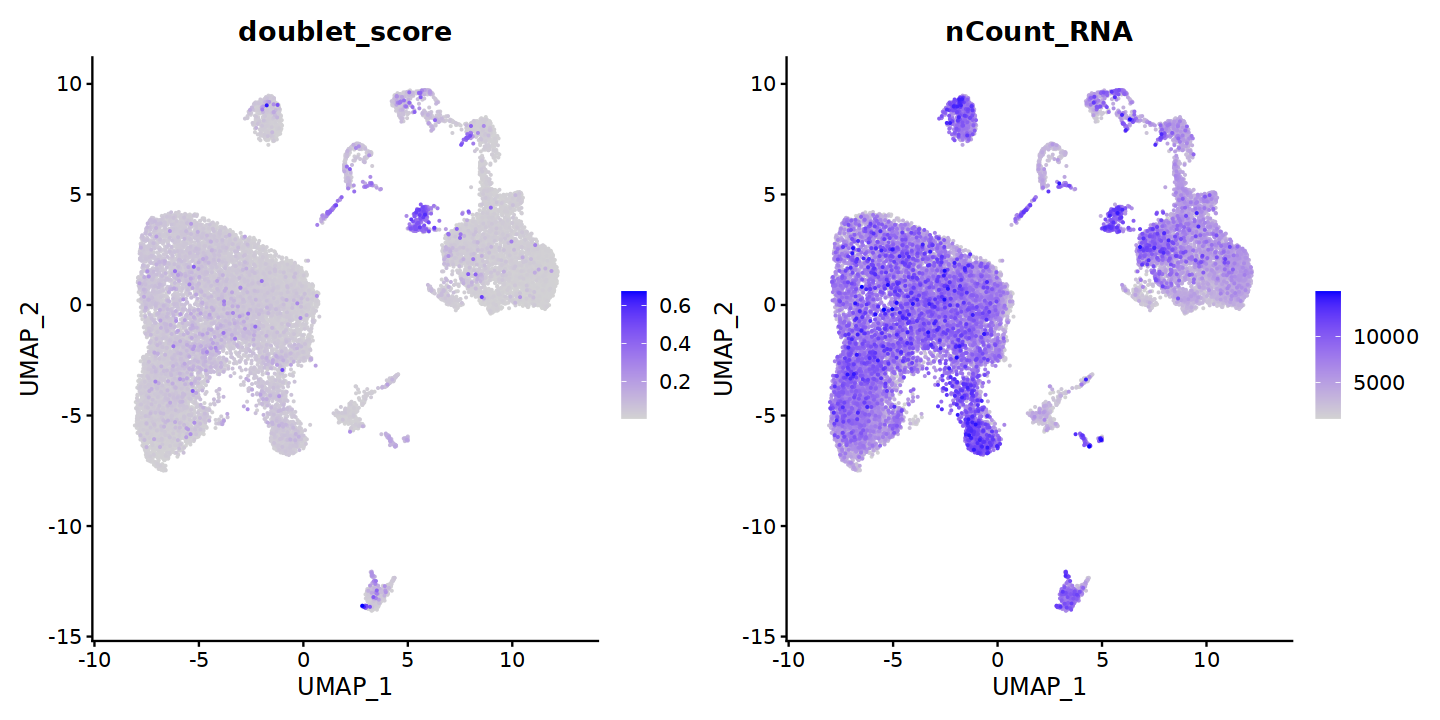

In [19]:
options(repr.plot.width = 12, repr.plot.height = 6, warn=-1,verbose = FALSE)
FeaturePlot(seurat_obj, reduction = "umap", 
            feature=c("doublet_score", "nCount_RNA"), order = TRUE)

In [20]:
head(seurat_obj@meta.data)

orig.ident   nCount_RNA nFeature_RNA sample_org
T1_1_AAACCTGAGAAGGCCT-1 SCGRES_83_84  8579      3076         OS0007_1  
T1_1_AAACCTGAGATCCCGC-1 SCGRES_83_84  2813      1518         OS0007_1  
T1_1_AAACCTGAGATGTGGC-1 SCGRES_83_84  2333      1252         OS0007_1  
T1_1_AAACCTGAGGGAACGG-1 SCGRES_83_84 14188      3889         OS0007_1  
T1_1_AAACCTGCACAAGACG-1 SCGRES_83_84  7127      2680         OS0007_1  
T1_1_AAACCTGCACCGTTGG-1 SCGRES_83_84  4171      2080         OS0007_1  
                        timepoint replicate sample_id pct_mt   percent.ribo
T1_1_AAACCTGAGAAGGCCT-1 T1        1         T1_1      1.153981  8.777247   
T1_1_AAACCTGAGATCCCGC-1 T1        1         T1_1      3.128333 14.041948   
T1_1_AAACCTGAGATGTGGC-1 T1        1         T1_1      3.771967  8.058294   
T1_1_AAACCTGAGGGAACGG-1 T1        1         T1_1      1.557654 10.572315   
T1_1_AAACCTGCACAAGACG-1 T1        1         T1_1      2.259015 20.148730   
T1_1_AAACCTGCACCGTTGG-1 T1        1         T1_1      2.397507  9.470151   
                        doublet_score doublet_pred S.Score     G2M.Score   
T1_1_AAACCTGAGAAGGCCT-1 0.01767429    FALSE        -0.07996875 -0.043351675
T1_1_AAACCTGAGATCCCGC-1 0.03388889    FALSE        -0.06454767  0.007223489
T1_1_AAACCTGAGATGTGGC-1 0.01492339    FALSE        -0.04395379  0.008541046
T1_1_AAACCTGAGGGAACGG-1 0.02187453    FALSE        -0.01683653 -0.026901698
T1_1_AAACCTGCACAAGACG-1 0.01767429    FALSE         0.05103090  0.006105521
T1_1_AAACCTGCACCGTTGG-1 0.06417328    FALSE         0.01798554 -0.043719719
                        Phase old.ident   
T1_1_AAACCTGAGAAGGCCT-1 G1    SCGRES_83_84
T1_1_AAACCTGAGATCCCGC-1 G2M   SCGRES_83_84
T1_1_AAACCTGAGATGTGGC-1 G2M   SCGRES_83_84
T1_1_AAACCTGAGGGAACGG-1 G1    SCGRES_83_84
T1_1_AAACCTGCACAAGACG-1 S     SCGRES_83_84
T1_1_AAACCTGCACCGTTGG-1 S     SCGRES_83_84

### First clustering to localize doublets

In [21]:
# Find the K-nearest neighbors
seurat_obj <- FindNeighbors(seurat_obj, reduction = "pca", dims = 1:15)
# Find clusters at different resolutions
clusters_df <- cluster_diff_resolutions(
  seurat_obj = seurat_obj,
  min_resolution = 0.1,
  max_resolution = 1.0,
  step = 0.1
)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 19310
Number of edges: 645474

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9613
Number of communities: 10
Elapsed time: 4 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 19310
Number of edges: 645474

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9423
Number of communities: 14
Elapsed time: 3 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 19310
Number of edges: 645474

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9286
Number of communities: 16
Elapsed time: 4 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 19310
Number of edges: 645474

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9168
Number of communities: 18
Elapsed time: 4 seconds
Modularity O

In [22]:
list_plots <- lapply(unique(clusters_df$resolution), function(x) {
  p <- add_reso_results(seurat_obj, clusters_df, resolution=x)
  umap <- DimPlot(p, reduction = "umap", 
                  group.by=glue::glue("seurat_clusters")) +
    labs(title=glue::glue("Resolution {x}"))
  return(umap)
})

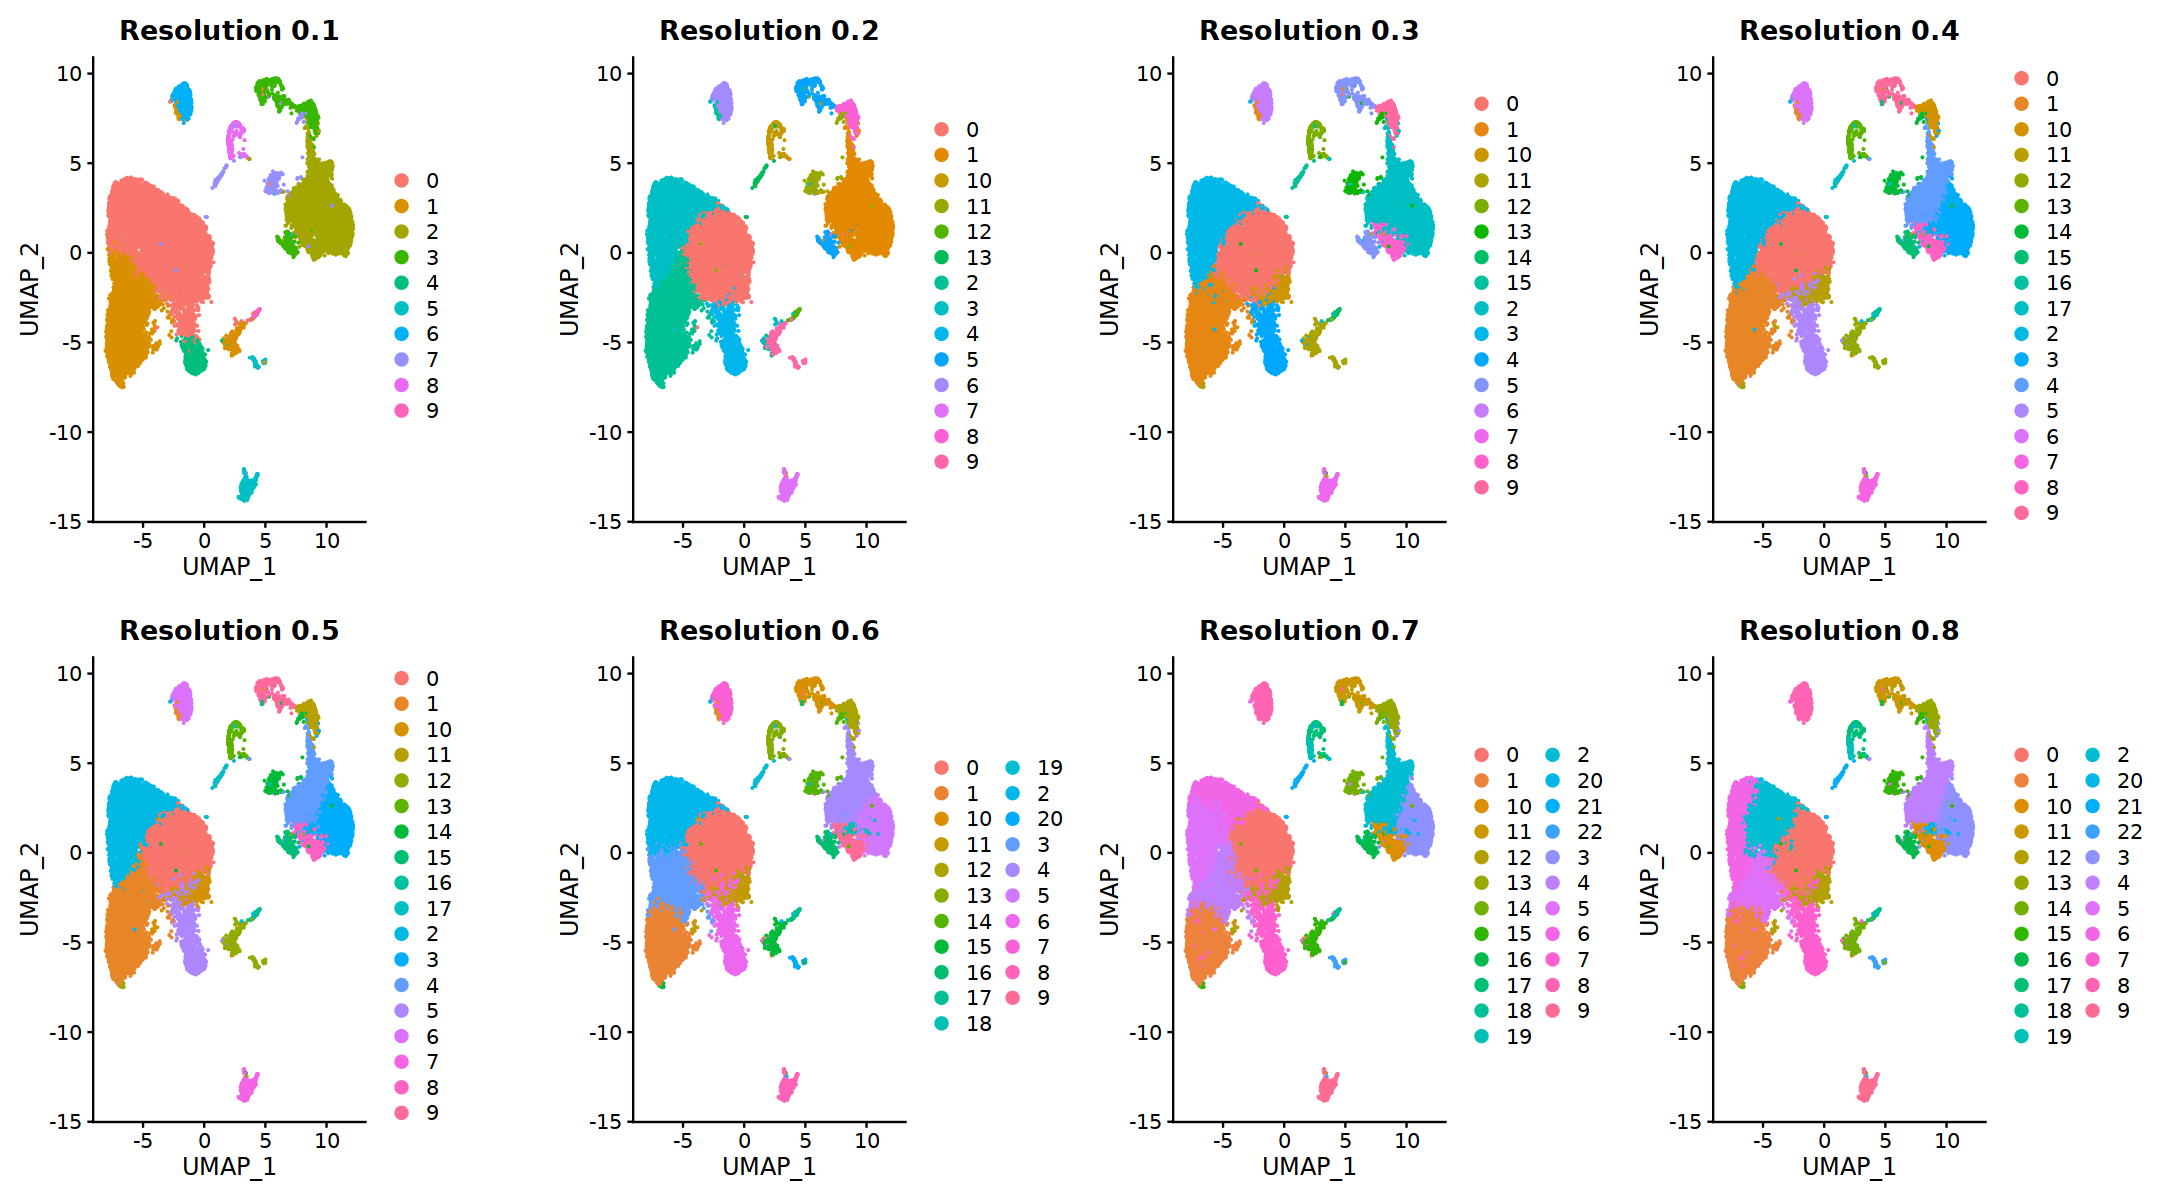

In [23]:
options(repr.plot.width = 18, repr.plot.height = 10, warn=-1,verbose = FALSE)
cp <- cowplot::plot_grid(plotlist = list_plots,
                   align = "hv",
                   axis = "trbl",
                   ncol=4,
                   nrow=2)
cp

In [24]:
seurat_obj <- FindClusters(seurat_obj, resolution = 0.2)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 19310
Number of edges: 645474

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9423
Number of communities: 14
Elapsed time: 3 seconds


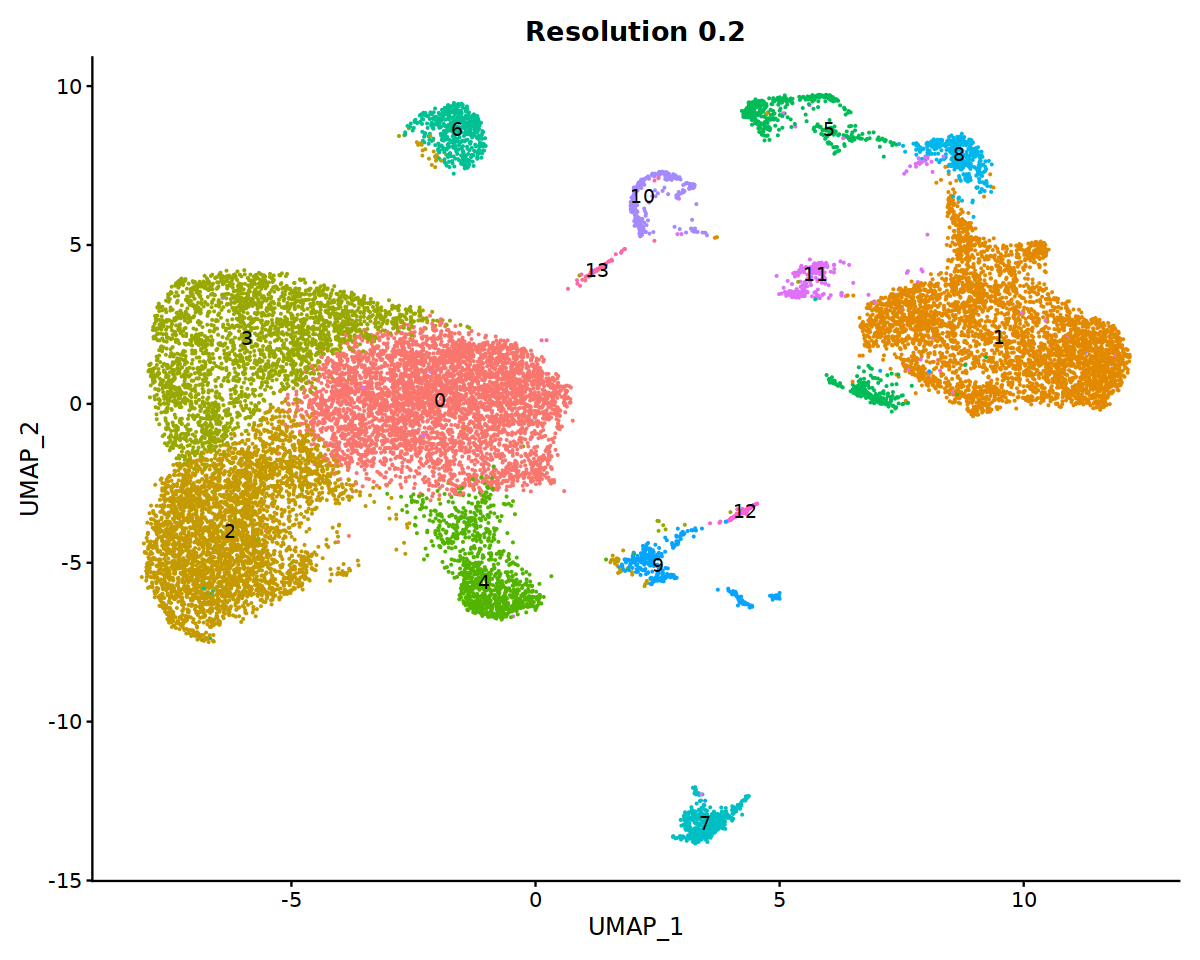

In [25]:
options(repr.plot.width = 10, repr.plot.height = 8, warn=-1,verbose = FALSE)
DimPlot(seurat_obj, reduction = "umap", label = T) + NoLegend() +
  labs(title="Resolution 0.2") + theme(plot.title = element_text(hjust = 0.5))

### Obtain markers to corroborate doublets by gene expression

In [26]:
rna.markers <- FindAllMarkers(seurat_obj, min.pct = 0.1, only.pos=T,
                              logfc.threshold = 0.1, random.seed=0, 
                              max.cells.per.ident=1000)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13



In [27]:
write_csv(rna.markers, here(glue("{clust}/{robj_dir}/3.2-first_clustering_{timepoint}.csv")))

In [28]:
markers <- c("PTPRC","nCount_RNA", "nFeature_RNA",
             "doublet_score",
             "CD3E", "CD3D","NCAM1","KLRD1","FCGR3A",
              "CD14", "CD68", 
              "S100A8", "SPP1", "CD163", "MSR1",
               "HBB")

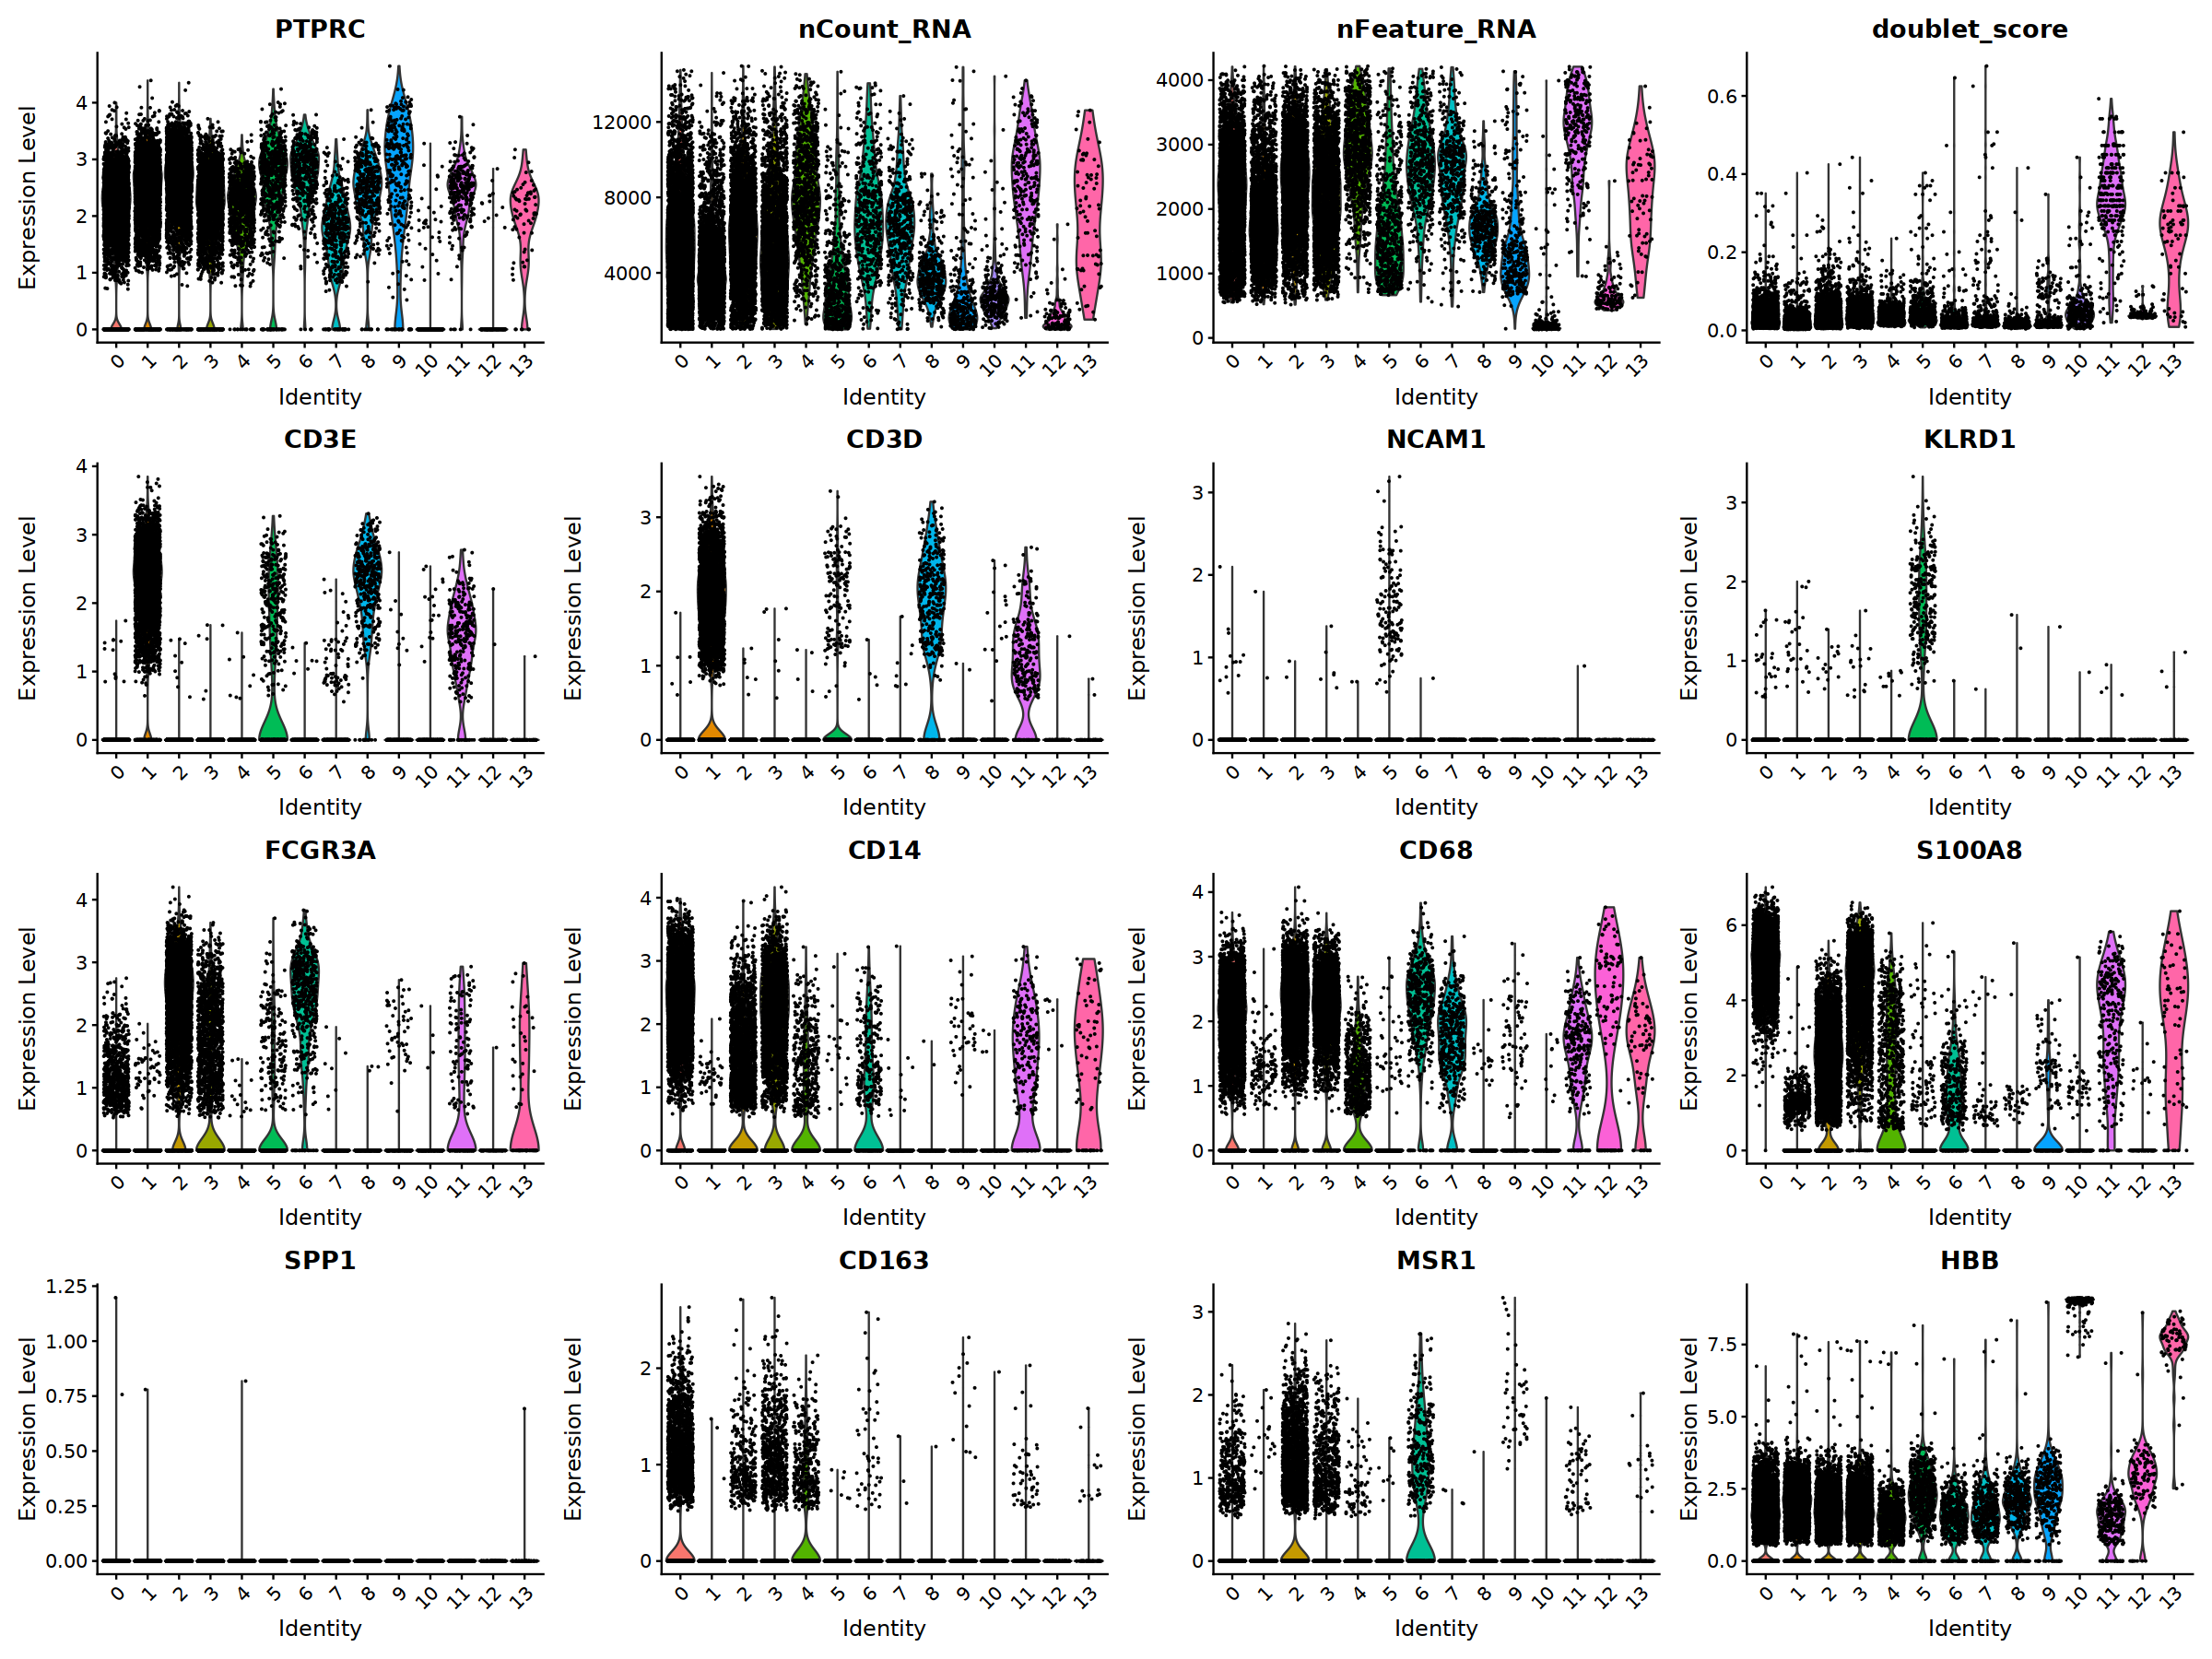

In [29]:
options(repr.plot.width = 20, repr.plot.height = 15, warn=-1,verbose = FALSE)
VlnPlot(seurat_obj, feature=markers, ncol=4)

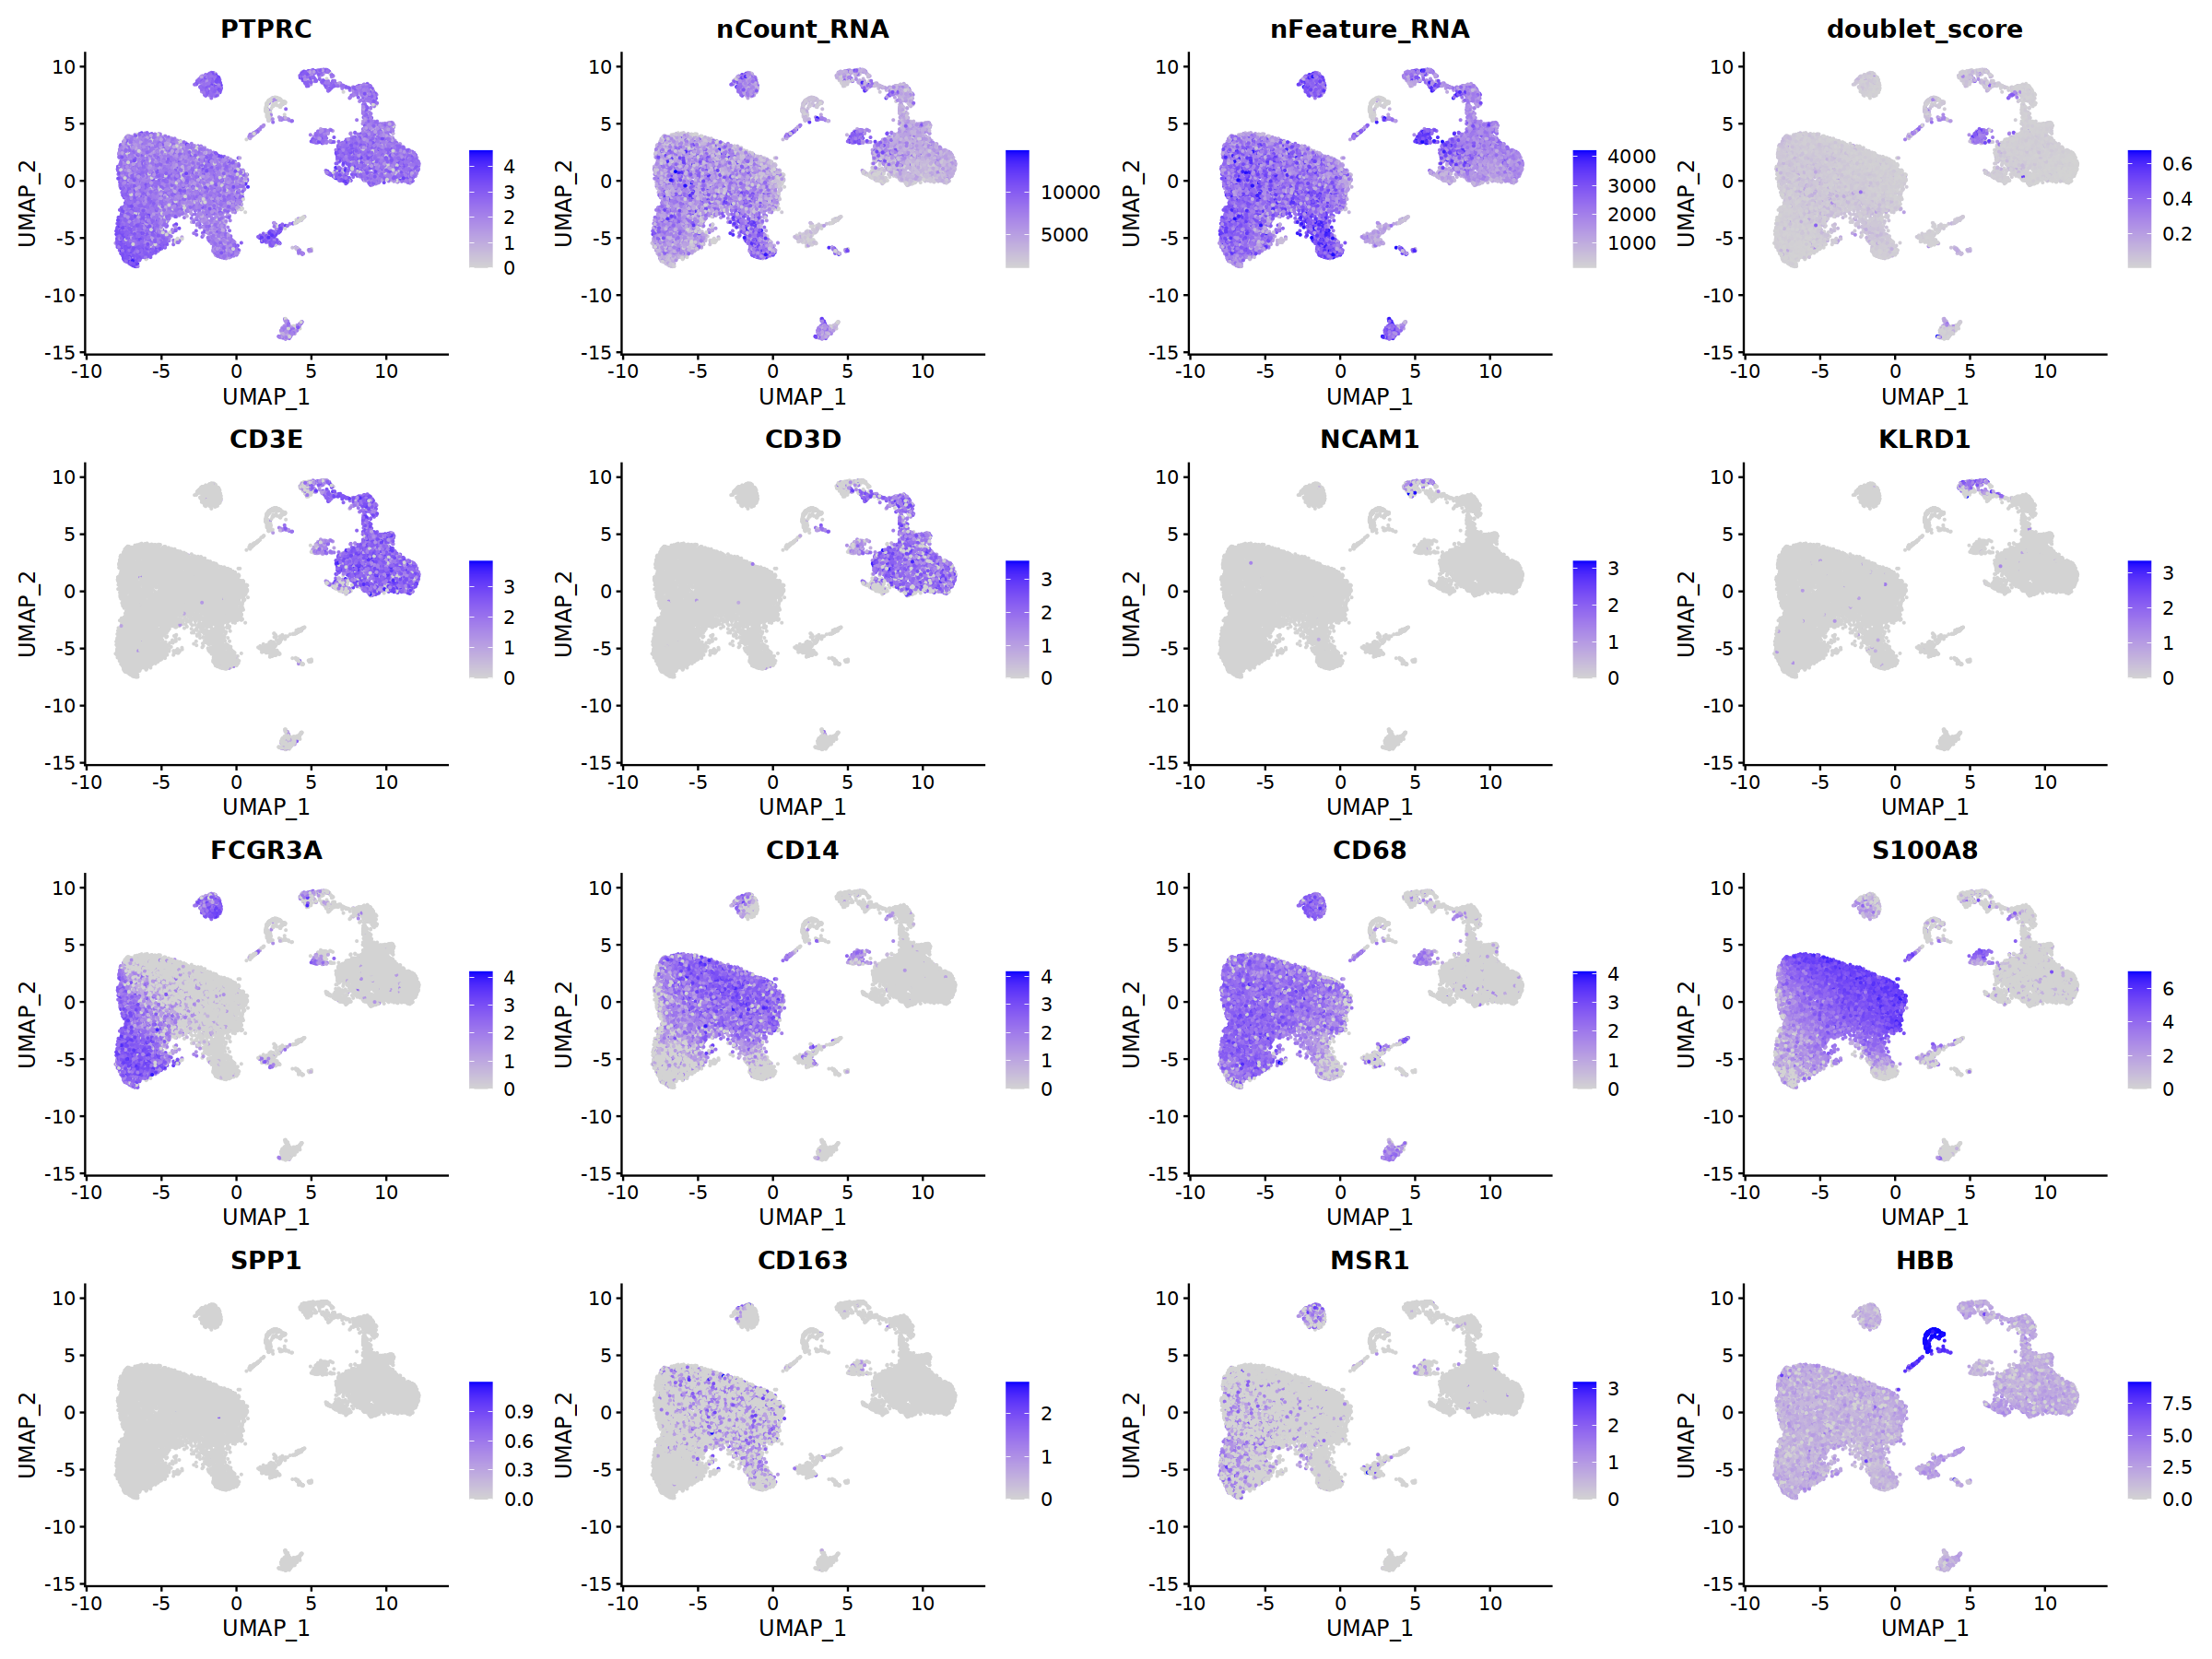

In [30]:
options(repr.plot.width = 20, repr.plot.height = 15, warn=-1,verbose = FALSE)
FeaturePlot(seurat_obj, ncol=4,
            feature=markers)

Low quality cells

In [31]:
c <- 9
rna.markers %>% 
  dplyr::filter(cluster == c) %>% 
  dplyr::filter(p_val_adj < 0.05) %>% 
  arrange(desc(avg_log2FC)) %>% head(n=15)

p_val        avg_log2FC pct.1 pct.2 p_val_adj    cluster gene     
MTRNR2L122 1.484854e-62 2.110179   0.973 0.949 4.119727e-58 9       MTRNR2L12
LRMDA5     2.368746e-26 2.074188   0.603 0.450 6.572086e-22 9       LRMDA    
SLC8A14    4.939656e-35 2.009598   0.697 0.561 1.370508e-30 9       SLC8A1   
MT-CO13    1.010787e-94 1.927157   0.987 0.988 2.804429e-90 9       MT-CO1   
NEAT14     2.856758e-43 1.912435   0.920 0.867 7.926076e-39 9       NEAT1    
DOCK23     6.527023e-48 1.912289   0.843 0.707 1.810922e-43 9       DOCK2    
MT-ATP84   3.401088e-51 1.846712   0.853 0.748 9.436318e-47 9       MT-ATP8  
MTSS13     5.534555e-23 1.834395   0.553 0.396 1.535562e-18 9       MTSS1    
MT-ND4L4   6.103818e-73 1.808367   0.950 0.838 1.693504e-68 9       MT-ND4L  
TCF7L23    8.563421e-23 1.766654   0.600 0.450 2.375921e-18 9       TCF7L2   
MT-CO24    1.122349e-82 1.765066   0.983 0.983 3.113957e-78 9       MT-CO2   
PRKCB4     9.966570e-40 1.761679   0.777 0.611 2.765225e-35 9       PRKCB    
LYN4       8.803423e-51 1.758965   0.907 0.712 2.442510e-46 9       LYN      
DENND1A5   8.785968e-40 1.758208   0.737 0.518 2.437667e-35 9       DENND1A  
MT-CYB4    1.265859e-76 1.749732   0.973 0.953 3.512126e-72 9       MT-CYB

Doublets

In [32]:
c <- 10
rna.markers %>% 
  dplyr::filter(cluster == c) %>% 
  dplyr::filter(p_val_adj < 0.05) %>% 
  arrange(desc(avg_log2FC)) %>% head(n=15)

p_val         avg_log2FC pct.1 pct.2 p_val_adj     cluster gene    
HBB      1.876464e-147 8.682605   1.000 0.906 5.206249e-143 10      HBB     
ALAS2    1.417163e-253 5.946860   0.983 0.029 3.931919e-249 10      ALAS2   
HBA2     2.275158e-236 5.833746   1.000 0.056 6.312427e-232 10      HBA2    
HBA1     1.073236e-245 5.297515   0.993 0.045 2.977693e-241 10      HBA1    
CA1      1.094093e-206 4.578677   0.815 0.015 3.035560e-202 10      CA1     
SLC25A37 3.099802e-189 4.502674   0.997 0.215 8.600400e-185 10      SLC25A37
SLC25A39 2.688044e-181 4.128253   0.965 0.196 7.457977e-177 10      SLC25A39
SNCA     1.492388e-205 4.120098   0.969 0.112 4.140631e-201 10      SNCA    
UBB3     4.671173e-119 3.873438   0.965 0.759 1.296017e-114 10      UBB     
HBD      7.658517e-138 3.838572   0.610 0.024 2.124856e-133 10      HBD     
IFI274   1.838122e-156 3.616497   0.997 0.323 5.099870e-152 10      IFI27   
AHSP     3.339214e-173 3.498085   0.707 0.012 9.264649e-169 10      AHSP    
DCAF121  1.755606e-157 3.086890   0.836 0.128 4.870930e-153 10      DCAF12  
TENT5C3  4.812373e-165 3.018489   0.899 0.155 1.335193e-160 10      TENT5C  
ADIPOR11 2.676878e-131 2.859088   0.927 0.375 7.426997e-127 10      ADIPOR1

In [33]:
c <- 11
rna.markers %>% 
  dplyr::filter(cluster == c) %>% 
  dplyr::filter(p_val_adj < 0.05) %>% 
  arrange(desc(avg_log2FC)) %>% head(n=15)

p_val        avg_log2FC pct.1 pct.2 p_val_adj    cluster gene  
BCL23   1.528183e-56 0.9366521  0.796 0.228 4.239942e-52 11      BCL2  
LTB2    7.351727e-55 0.7617377  0.981 0.380 2.039737e-50 11      LTB   
FAM13A1 6.517640e-36 0.7464397  0.641 0.217 1.808319e-31 11      FAM13A
BACH23  1.672081e-33 0.7336620  0.585 0.158 4.639188e-29 11      BACH2 
IL323   2.163644e-56 0.6899395  0.896 0.240 6.003031e-52 11      IL32  
PDE3B3  7.303890e-41 0.6820970  0.726 0.251 2.026464e-36 11      PDE3B 
IL7R2   1.575357e-45 0.6039541  0.741 0.193 4.370828e-41 11      IL7R  
INPP4B3 2.322687e-45 0.5978784  0.667 0.164 6.444295e-41 11      INPP4B
TCF73   1.115130e-40 0.5806225  0.633 0.159 3.093928e-36 11      TCF7  
ETS13   7.384090e-50 0.5655880  0.863 0.252 2.048716e-45 11      ETS1  
SKAP13  3.643103e-52 0.5597145  0.796 0.208 1.010779e-47 11      SKAP1 
MLLT33  1.627456e-31 0.5415673  0.574 0.170 4.515376e-27 11      MLLT3 
CD3E3   5.885962e-49 0.5409706  0.919 0.243 1.633060e-44 11      CD3E  
ANK32   1.477929e-26 0.5253497  0.389 0.090 4.100514e-22 11      ANK3  
ABLIM13 3.587048e-31 0.5202553  0.619 0.176 9.952264e-27 11      ABLIM1

In [34]:
c <- 13
rna.markers %>% 
  dplyr::filter(cluster == c) %>% 
  dplyr::filter(p_val_adj < 0.05) %>% 
  arrange(desc(avg_log2FC)) %>% head(n=15)

p_val         avg_log2FC pct.1 pct.2 p_val_adj     cluster gene    
HBB1       6.354706e-43 4.122267   1.000 0.907  1.763113e-38 13      HBB     
HBA21     5.694347e-115 3.477906   0.972 0.067 1.579897e-110 13      HBA2    
HBA11     7.213851e-135 3.113251   1.000 0.056 2.001483e-130 13      HBA1    
ALAS21    2.039922e-137 3.025839   0.917 0.040 5.659764e-133 13      ALAS2   
SLC25A372  6.674586e-61 2.636743   0.958 0.224  1.851864e-56 13      SLC25A37
CA11      6.687919e-107 2.451672   0.708 0.024 1.855563e-102 13      CA1     
SLC25A391  4.520391e-45 2.247602   0.833 0.205  1.254182e-40 13      SLC25A39
SNCA2      1.162738e-76 2.154546   0.931 0.122  3.226018e-72 13      SNCA    
IFI276     3.025623e-28 1.742267   0.944 0.330  8.394590e-24 13      IFI27   
UBB4       3.850918e-24 1.701637   0.958 0.761  1.068437e-19 13      UBB     
DCAF122    1.126883e-37 1.523444   0.694 0.136  3.126538e-33 13      DCAF12  
HBD2       1.419282e-49 1.411993   0.472 0.031  3.937798e-45 13      HBD     
TENT5C5    6.801383e-43 1.347325   0.792 0.163  1.887044e-38 13      TENT5C  
FAM210B1   3.452193e-40 1.308670   0.486 0.058  9.578108e-36 13      FAM210B 
ADIPOR13   4.271444e-25 1.292849   0.875 0.382  1.185112e-20 13      ADIPOR1

### Remove cells

Doublets, low quality etc 

In [35]:
seurat_obj <- subset(seurat_obj, idents=c(9,10,11,13), invert=TRUE)

In [36]:
print(table(rowSums(as.matrix(seurat_obj[['RNA']]@counts)) == 0))
  
keep_genes <- data.frame(rowSums(as.matrix(seurat_obj[['RNA']]@counts)) != 0)
colnames(keep_genes) <- "logical"
keep_genes <- subset(keep_genes, logical==TRUE)
seurat_obj[['RNA']]@counts <- seurat_obj[['RNA']]@counts[rownames(keep_genes), ]
seurat_obj[['RNA']]@data <- seurat_obj[['RNA']]@data[rownames(keep_genes), ]
seurat_obj


FALSE  TRUE 
27505   240 


An object of class Seurat 
27505 features across 18381 samples within 1 assay 
Active assay: RNA (27505 features, 0 variable features)
 2 dimensional reductions calculated: pca, umap

## Re-do embedding and clustering

In [37]:
seurat_obj <- NormalizeData(
  seurat_obj,
  normalization.method = "LogNormalize",
  scale.factor = 1e4
)

In [38]:
sce <- as.SingleCellExperiment(seurat_obj)
sce

class: SingleCellExperiment 
dim: 27505 18381 
metadata(0):
assays(2): counts logcounts
rownames(27505): MIR1302-2HG AL627309.1 ... AC010086.3 AC004556.3
rowData names(0):
colnames(18381): T1_1_AAACCTGAGAAGGCCT-1 T1_1_AAACCTGAGATCCCGC-1 ...
  T1_2_TTTGTCATCGTTACGA-1 T1_2_TTTGTCATCTGAAAGA-1
colData names(18): orig.ident nCount_RNA ... seurat_clusters ident
reducedDimNames(2): PCA UMAP
mainExpName: RNA
altExpNames(0):

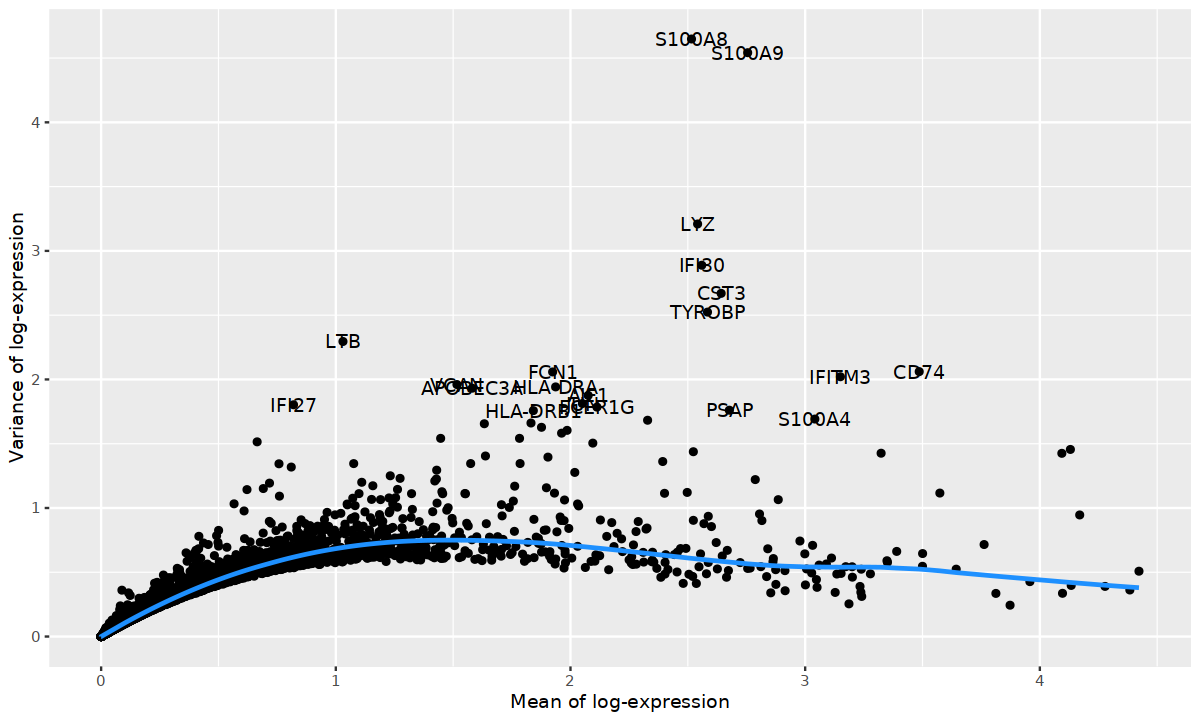

In [39]:
options(repr.plot.width = 10, repr.plot.height = 6, warn=-1,verbose = FALSE)
gene_var <- modelGeneVar(sce)

tops <- gene_var %>% 
    as.data.frame() %>% 
    arrange(desc(total)) %>% 
    head(n=20)

gene_var %>% 
  as.data.frame() %>% 
  ggplot(aes(mean, total)) +
  geom_point() +
  geom_line(aes(y = tech), colour = "dodgerblue", size = 1) +
  labs(x = "Mean of log-expression", y = "Variance of log-expression")+
  geom_text(data=tops, aes(mean,total,label=rownames(tops)))

In [40]:
hvgs <- getTopHVGs(gene_var,fdr.threshold = 0.05)
length(hvgs)

[1] 702

In [41]:
hvgs <- hvgs[!grepl("^TR[ABDG][VJC]", hvgs)]
length(hvgs)

[1] 600

In [42]:
seurat_obj <- seurat_obj %>%
  ScaleData(features=hvgs) %>% 
  RunPCA(features=hvgs)

Centering and scaling data matrix

PC_ 1 
Positive:  CD3E, LTB, IL32, ETS1, PCED1B-AS1, CD69, CD3D, SKAP1, IL7R, CD7 
	   RHOH, CD247, LCK, LEF1, FLT3LG, MALAT1, BCL2, ITK, PIM2, CAMK4 
	   TRAT1, LIME1, PRKCH, SPOCK2, ITM2A, MAL, TCF7, ABLIM1, INPP4B, BCL11B 
Negative:  CST3, TYROBP, IFI30, FCER1G, AIF1, FCN1, IFITM3, PSAP, LYZ, CTSS 
	   SPI1, SERPINA1, LYN, ZEB2, LST1, NAMPT, TYMP, S100A6, MNDA, S100A11 
	   FTL, LGALS1, S100A9, CD68, HLA-DRB1, HLA-DRA, CD74, FTH1, APOBEC3A, SRGN 
PC_ 2 
Positive:  JCHAIN, LILRA4, CLEC4C, MZB1, NIBAN3, RHEX, PTPRS, IGKC, SERPINF1, LINC01374 
	   LINC01478, LINC00996, COBLL1, SPIB, DERL3, TCF4, ITM2C, CUX2, GZMB, RGS7 
	   CLIC3, AFF3, TCL1A, HLA-DQA1, CD74, HLA-DPB1, HLA-DRA, RBMS3, HLA-DPA1, PTCRA 
Negative:  IFITM1, JUNB, CD52, S100A10, FOS, JUN, ANXA1, DUSP1, FLT3LG, IL7R 
	   IL32, NEAT1, CD3D, CD69, TNFAIP3, CD3E, FTL, IFITM3, TRAT1, LCK 
	   SPOCK2, LEF1, S100A4, MAL, ITK, CAMK4, ICOS, BCL2, INPP4B, TCF7 
PC_ 3 
Positive:  CCL5, GP9, TUBB1, PP

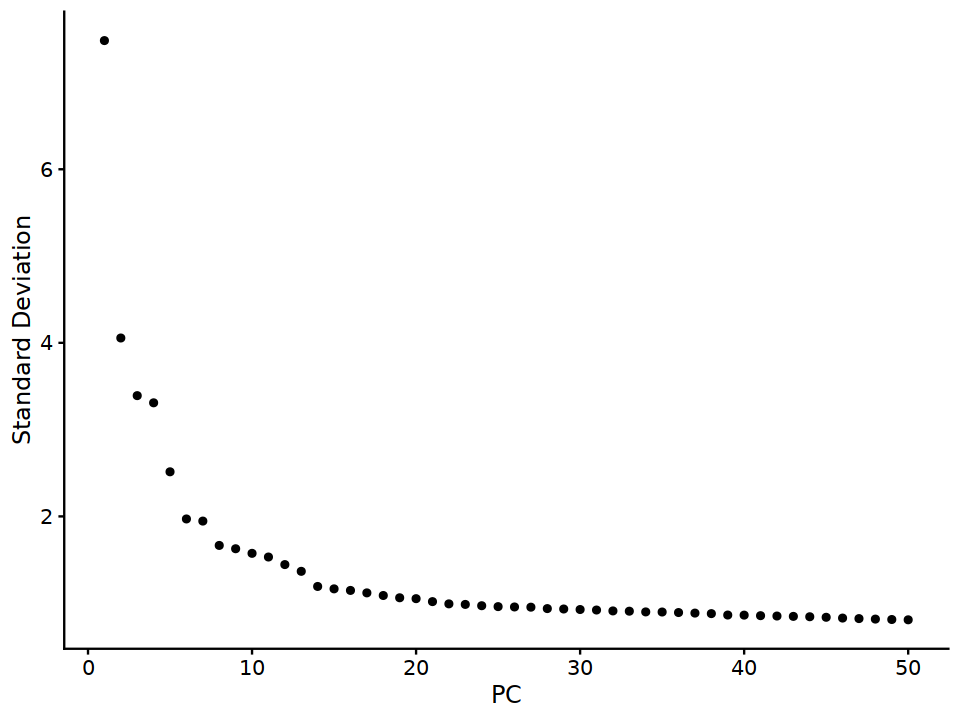

In [43]:
options(repr.plot.width = 8, repr.plot.height = 6)
ElbowPlot(seurat_obj, n=50)

In [44]:
seurat_obj <- RunUMAP(
  seurat_obj,
  dims = 1:15,
  reduction = "pca",
  reduction.name = "umap",
  reduction.key = "UMAP_"
)

16:55:18 UMAP embedding parameters a = 0.9922 b = 1.112

16:55:18 Read 18381 rows and found 15 numeric columns

16:55:18 Using Annoy for neighbor search, n_neighbors = 30

16:55:18 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

16:55:20 Writing NN index file to temp file /scratch_tmp/33937378/RtmpMsZ3tu/filef134a2c95a3

16:55:20 Searching Annoy index using 1 thread, search_k = 3000

16:55:26 Annoy recall = 100%

16:55:27 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

16:55:29 Initializing from normalized Laplacian + noise (using irlba)

16:55:29 Commencing optimization for 200 epochs, with 766024 positive edges

16:55:49 Optimization finished



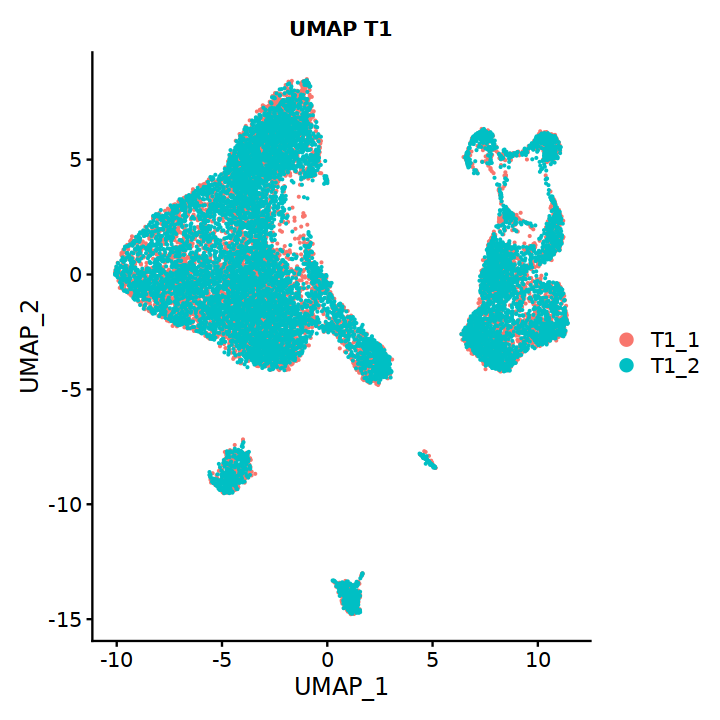

In [45]:
options(repr.plot.width = 6, repr.plot.height = 6, warn=-1,verbose = FALSE)
DimPlot(
  seurat_obj,
  reduction = "umap",
  group.by = "sample_id",
  pt.size = 0.1
) + ggtitle(glue('UMAP {timepoint}')) + 
    theme(plot.title = element_text(hjust = 0.5, size = 12, face = "bold"))

### Clustering 

In [46]:
seurat_obj <- FindNeighbors(seurat_obj, reduction = "pca", dims = 1:15)

Computing nearest neighbor graph

Computing SNN



In [47]:
reso = 0.2

In [48]:
seurat_obj <- FindClusters(seurat_obj, resolution = reso)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 18381
Number of edges: 618695

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9398
Number of communities: 10
Elapsed time: 3 seconds


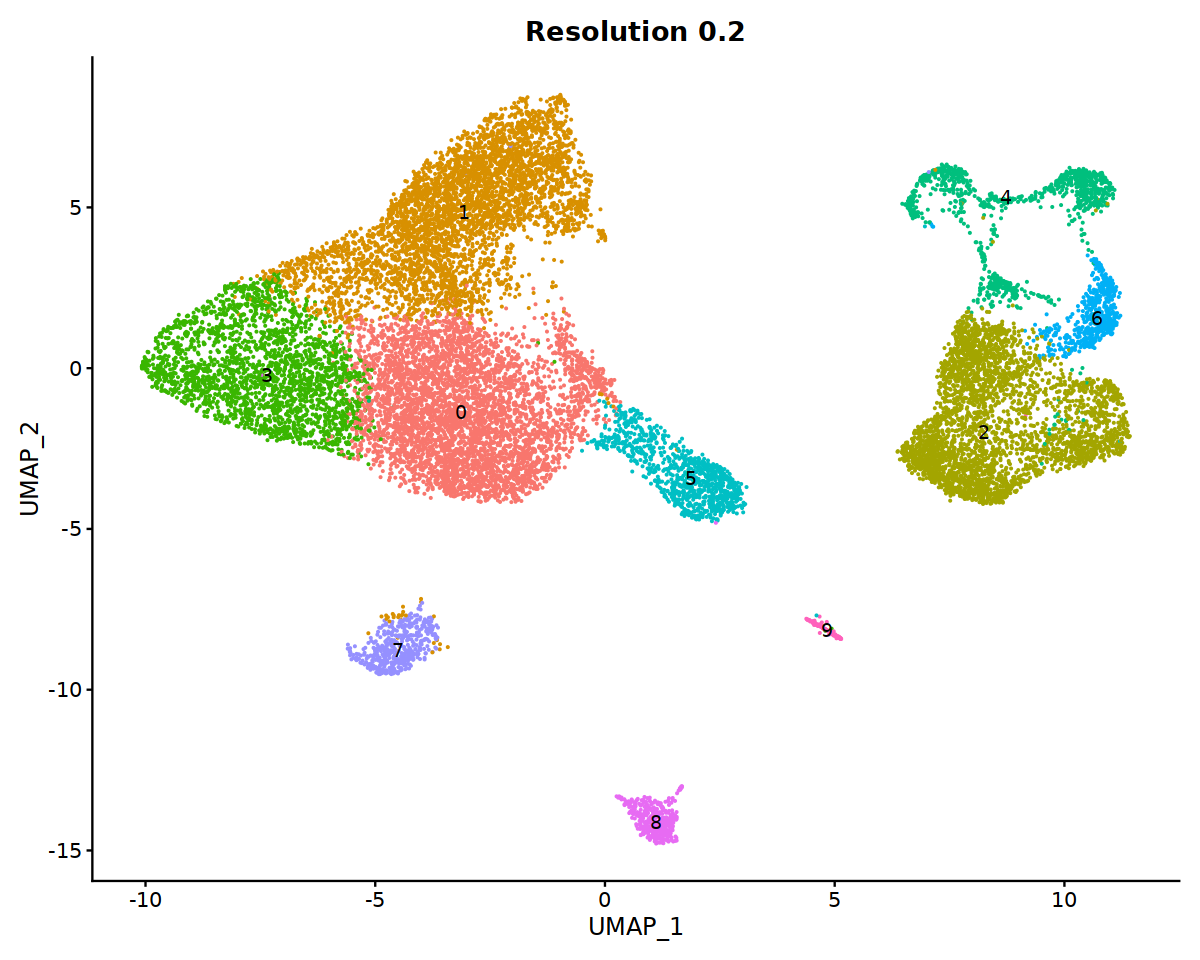

In [49]:
options(repr.plot.width = 10, repr.plot.height = 8, warn=-1,verbose = FALSE)
DimPlot(seurat_obj, reduction = "umap", label = T)+ NoLegend() +
  labs(title=glue("Resolution {reso}")) + theme(plot.title = element_text(hjust = 0.5))

### Compute markers

In [50]:
rna.markers <- FindAllMarkers(seurat_obj, min.pct=0.1, 
                              logfc.threshold=0.1, only.pos=T,
                              random.seed=0, max.cells.per.ident=1000)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9



# Save

In [51]:
saveRDS(seurat_obj, here::here(glue::glue("{clust}/{robj_dir}/3.2-clustering_{timepoint}.rds")))

In [52]:
write_csv(rna.markers, here(glue("{clust}/{robj_dir}/3.2-clustering_{timepoint}.csv")))

# Session Info

In [53]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /home/groups/singlecell/isentis/conda_envs/ines_r4.1.1c/lib/libopenblasp-r0.3.24.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=es_ES.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=es_ES.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=es_ES.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=es_ES.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    grid      stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] scran_1.22.1                scater_1.22.0              
 [3] scuttle_1.4.0               SingleCellExperiment_1.16.0
 [5] SummarizedExperiment_1.24.0 Biobase_2.54.0             
 [7] GenomicRanges_1.46.1        GenomeInfoDb_1.30.1        
 [9] IRanges_